In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file_path = 'Preprocessed_data_corrected.csv'
df = pd.read_csv(file_path)
df

,Date Time,FLOW(m3/h),VELOCITY(m/s),Pressure,No_Water_Supply,Pressure_Drop,Flow_Change
0,01/01/24 00:00,44.75,0.30,1.37,0,0.00,0.00
1,01/01/24 00:00,0.00,0.00,0.00,1,-1.37,-44.75
2,01/01/24 00:00,47.00,0.32,1.37,0,1.37,47.00
3,01/01/24 00:01,46.50,0.31,1.38,0,0.01,-0.50
4,01/01/24 00:01,45.50,0.31,1.38,0,0.00,-1.00
...,...,...,...,...,...,...,...
234286,26/01/24 15:37,87.00,0.58,1.31,0,0.00,-0.50
234287,26/01/24 15:37,86.50,0.58,1.31,0,0.00,-0.50
234288,26/01/24 15:37,83.00,0.56,1.30,0,-0.01,-3.50
234289,26/01/24 15:37,82.00,0.55,1.30,0,0.00,-1.00


In [3]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d/%m/%y %H:%M')

In [4]:
df.describe()

,Date Time,FLOW(m3/h),VELOCITY(m/s),Pressure,No_Water_Supply,Pressure_Drop,Flow_Change
count,234291,234291.000000,234291.000000,234291.000000,234291.000000,2.342910e+05,234291.000000
mean,2024-01-11 09:26:07.378516224,72.569539,0.486770,1.008747,0.030274,-2.987737e-07,0.000165
min,2024-01-01 00:00:00,-1.990000,-2.000000,-2.000000,0.000000,-3.310000e+00,-236.000000
25%,2024-01-05 17:56:00,46.000000,0.310000,0.990000,0.000000,0.000000e+00,-1.420000
50%,2024-01-11 03:02:00,74.500000,0.500000,1.240000,0.000000,0.000000e+00,0.000000
75%,2024-01-16 03:10:00,102.000000,0.680000,1.300000,0.000000,0.000000e+00,1.000000
max,2024-01-26 15:37:00,249.000000,2.510000,2.510000,1.000000,3.310000e+00,247.000000
std,NaN,42.202560,0.283556,0.462212,0.171341,1.968145e-01,12.633544


In [5]:
# Feature Engineering: create rolling averages, diffs for flow, pressure, velocity
df['Flow_Diff'] = df['FLOW(m3/h)'].diff()
df['Pressure_Diff'] = df['Pressure'].diff()
df['Velocity_Diff'] = df['VELOCITY(m/s)'].diff()

# Drop rows with missing values (from diff calculation)
df.dropna(inplace=True)
df

,Date Time,FLOW(m3/h),VELOCITY(m/s),Pressure,No_Water_Supply,Pressure_Drop,Flow_Change,Flow_Diff,Pressure_Diff,Velocity_Diff
1,2024-01-01 00:00:00,0.0,0.00,0.00,1,-1.37,-44.75,-44.75,-1.37,-0.30
2,2024-01-01 00:00:00,47.0,0.32,1.37,0,1.37,47.00,47.00,1.37,0.32
3,2024-01-01 00:01:00,46.5,0.31,1.38,0,0.01,-0.50,-0.50,0.01,-0.01
4,2024-01-01 00:01:00,45.5,0.31,1.38,0,0.00,-1.00,-1.00,0.00,0.00
5,2024-01-01 00:01:00,45.5,0.31,1.38,0,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
234286,2024-01-26 15:37:00,87.0,0.58,1.31,0,0.00,-0.50,-0.50,0.00,-0.01
234287,2024-01-26 15:37:00,86.5,0.58,1.31,0,0.00,-0.50,-0.50,0.00,0.00
234288,2024-01-26 15:37:00,83.0,0.56,1.30,0,-0.01,-3.50,-3.50,-0.01,-0.02
234289,2024-01-26 15:37:00,82.0,0.55,1.30,0,0.00,-1.00,-1.00,0.00,-0.01


In [ ]:
# Define thresholds for burst/leak events
flow_threshold = -50  # large negative flow change
pressure_threshold =  -1.3 #  significant pressure drop
velocity_threshold =  -0.1 # sudden drop in velocity

# if all conditions are met, mark as leak is (1), otherwise no leak (0)
df['burst_or_leak_label'] = (
    (df['Flow_Diff'] < flow_threshold) &
    (df['Pressure_Diff'] < pressure_threshold) &
    (df['Velocity_Diff'] < velocity_threshold)
).astype(int)


In [19]:
# Target (1 if burst/leak, 0 otherwise - needs historical labeling)
X = df[['Flow_Diff', 'Pressure_Diff', 'Velocity_Diff']]
y = df['burst_or_leak_label']  # Make sure you have a labeled dfset

# Split df into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70259
           1       1.00      1.00      1.00        28

    accuracy                           1.00     70287
   macro avg       1.00      1.00      1.00     70287
weighted avg       1.00      1.00      1.00     70287



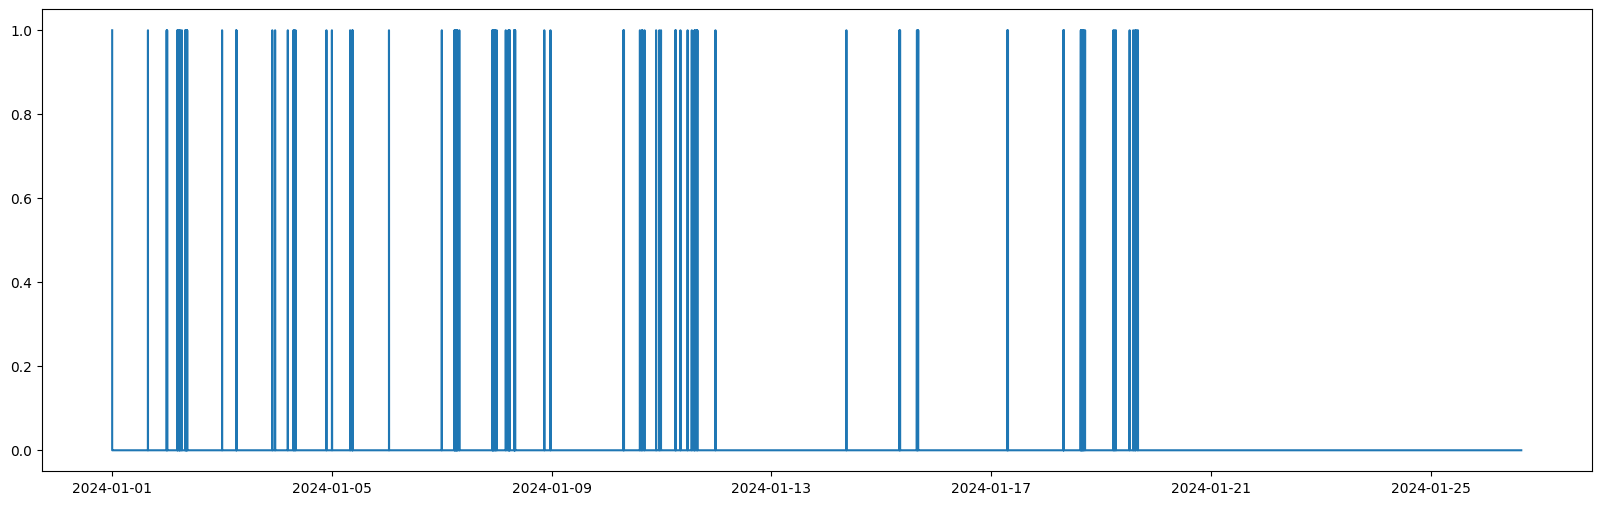

In [20]:
plt.figure(figsize=(20,6))
plt.plot(df['Date Time'], df['burst_or_leak_label'])

In [21]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d-%m-%Y %H:%M')
burst_or_leak_events = df[df['burst_or_leak_label'] == 1]
print(burst_or_leak_events[['Date Time', 'FLOW(m3/h)', 'Pressure', 'VELOCITY(m/s)']])

                 Date Time  FLOW(m3/h)  Pressure  VELOCITY(m/s)
1      2024-01-01 00:00:00         0.0       0.0            0.0
16784  2024-01-01 15:38:00         0.0       0.0            0.0
20365  2024-01-01 23:48:00         0.0       0.0            0.0
20524  2024-01-02 00:01:00         0.0       0.0            0.0
23623  2024-01-02 04:27:00         0.0       0.0            0.0
...                    ...         ...       ...            ...
213985 2024-01-19 14:05:00         0.0       0.0            0.0
214043 2024-01-19 14:54:00         0.0       0.0            0.0
214057 2024-01-19 15:05:00         0.0       0.0            0.0
214067 2024-01-19 15:34:00         0.0       0.0            0.0
214173 2024-01-19 16:09:00         0.0       0.0            0.0

[109 rows x 4 columns]


In [22]:
burst_or_leak_events

,Date Time,FLOW(m3/h),VELOCITY(m/s),Pressure,No_Water_Supply,Pressure_Drop,Flow_Change,Flow_Diff,Pressure_Diff,Velocity_Diff,burst_or_leak_label
1,2024-01-01 00:00:00,0.0,0.0,0.0,1,-1.37,-44.75,-44.75,-1.37,-0.30,1
16784,2024-01-01 15:38:00,0.0,0.0,0.0,1,-1.32,-86.00,-86.00,-1.32,-0.58,1
20365,2024-01-01 23:48:00,0.0,0.0,0.0,1,-1.40,-58.00,-58.00,-1.40,-0.39,1
20524,2024-01-02 00:01:00,0.0,0.0,0.0,1,-1.40,-46.00,-46.00,-1.40,-0.31,1
23623,2024-01-02 04:27:00,0.0,0.0,0.0,1,-1.44,-51.25,-51.25,-1.44,-0.34,1
...,...,...,...,...,...,...,...,...,...,...,...
213985,2024-01-19 14:05:00,0.0,0.0,0.0,1,-1.35,-109.00,-109.00,-1.35,-0.73,1
214043,2024-01-19 14:54:00,0.0,0.0,0.0,1,-1.33,-113.00,-113.00,-1.33,-0.76,1
214057,2024-01-19 15:05:00,0.0,0.0,0.0,1,-1.36,-112.50,-112.50,-1.36,-0.76,1
214067,2024-01-19 15:34:00,0.0,0.0,0.0,1,-1.35,-107.00,-107.00,-1.35,-0.72,1


In [23]:
burst_or_leak_events.describe()

,Date Time,FLOW(m3/h),VELOCITY(m/s),Pressure,No_Water_Supply,Pressure_Drop,Flow_Change,Flow_Diff,Pressure_Diff,Velocity_Diff,burst_or_leak_label
count,109,109.0,109.000000,109.000000,109.0,109.000000,109.000000,109.000000,109.000000,109.000000,109.0
mean,2024-01-09 17:33:24.770642176,0.0,0.013853,-0.014862,1.0,-1.372661,-79.740826,-79.740826,-1.372661,-0.521009,1.0
min,2024-01-01 00:00:00,0.0,0.000000,-1.620000,1.0,-2.870000,-151.000000,-151.000000,-2.870000,-1.010000,1.0
25%,2024-01-05 00:00:00,0.0,0.000000,0.000000,1.0,-1.380000,-93.500000,-93.500000,-1.380000,-0.620000,1.0
50%,2024-01-08 07:36:00,0.0,0.000000,0.000000,1.0,-1.350000,-75.500000,-75.500000,-1.350000,-0.490000,1.0
75%,2024-01-14 08:46:00,0.0,0.000000,0.000000,1.0,-1.330000,-57.750000,-57.750000,-1.330000,-0.380000,1.0
max,2024-01-19 16:09:00,0.0,0.940000,0.000000,1.0,-1.310000,-42.750000,-42.750000,-1.310000,-0.030000,1.0
std,NaN,0.0,0.104862,0.155168,0.0,0.148789,25.303526,25.303526,0.148789,0.177753,0.0
